<a href="https://colab.research.google.com/github/fatwaman/Learning_Python/blob/main/Deteksi_Pneumonia_dari_Citra_X_Ray_Dada_Menggunakan_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
!pip install tensorflow --quiet

In [ ]:
import opendatasets as od
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Download dataset dari Kaggle
# Anda akan diminta memasukkan username dan key Kaggle API Anda
# Anda bisa mendapatkannya dari akun Kaggle Anda di bagian 'API' -> 'Create New API Token'
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

# Tentukan path direktori data
train_dir = './chest-xray-pneumonia/chest_xray/train'
test_dir = './chest-xray-pneumonia/chest_xray/test'

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Paundra Krisna
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:26<00:00, 91.7MB/s]


Contoh Gambar Normal:


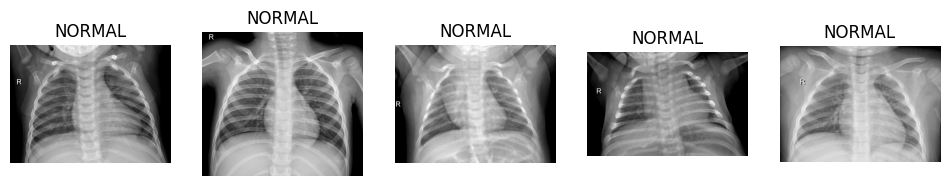


Contoh Gambar Pneumonia:


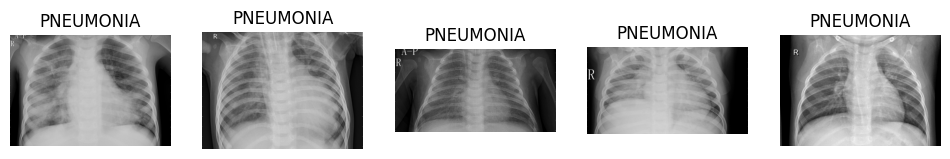

In [ ]:
# Mari kita lihat beberapa contoh gambar
def plot_sample_images(directory, class_name):
    plt.figure(figsize=(12, 4))
    class_path = os.path.join(directory, class_name)
    image_files = os.listdir(class_path)[:5]
    for i, image_file in enumerate(image_files):
        img = plt.imread(os.path.join(class_path, image_file))
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(class_name)
        plt.axis('off')
    plt.show()

print("Contoh Gambar Normal:")
plot_sample_images(train_dir, 'NORMAL')
print("\nContoh Gambar Pneumonia:")
plot_sample_images(train_dir, 'PNEUMONIA')

In [ ]:
# Ukuran gambar yang akan digunakan
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Membuat generator untuk data training dan validasi
# Augmentasi diterapkan pada data training untuk mencegah overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 # Kita pisahkan 20% data training untuk validasi
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Membangun arsitektur model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Sigmoid untuk klasifikasi biner
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=15 # Anda bisa menambah jumlah epoch untuk akurasi yang lebih baik
)

# Simpan model yang sudah dilatih
model.save('pneumonia_detector.h5')

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.7636 - loss: 0.5501 - val_accuracy: 0.8281 - val_loss: 0.3442
Epoch 2/15
  1/130 ━━━━━━━━━━━━━━━━━━━━ 3:15 2s/step - accuracy: 0.8125 - loss: 0.4243

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - accuracy: 0.8125 - loss: 0.4243 - val_accuracy: 0.8506 - val_loss: 0.3159
Epoch 3/15
 32/130 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - accuracy: 0.8564 - loss: 0.3099

In [ ]:
# Evaluasi model
loss, accuracy = model.evaluate(test_generator)
print(f"\nAkurasi pada data test: {accuracy*100:.2f}%")